### Importing all the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import r2_score, roc_auc_score,mean_squared_error
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve

from pprint import pprint

### Reading the datasets

In [2]:
train = pd.read_csv('training.csv')
test = pd.read_csv('testingCandidate.csv')
print('Shape of train data -', train.shape)
print('Shape of test data -', test.shape)

Shape of train data - (8238, 24)
Shape of test data - (32950, 22)


In [53]:
train.columns

Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded', 'profit', 'id', 'type'],
      dtype='object')

# Exploratory Data Analysis

In [76]:
train.groupby('responded').mean()

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,profit,id
responded,,,,,,,,,,,,,
no,39.840852,2.590834,983.920793,0.143639,0.225472,93.598417,-40.639083,3.782107,5174.874884,983.833516,0.289603,NaN,3655.5
yes,40.870968,2.065733,779.709052,0.493534,-1.275431,93.354830,-40.096013,2.049483,5092.326940,778.362177,0.963362,172.112069,7774.5


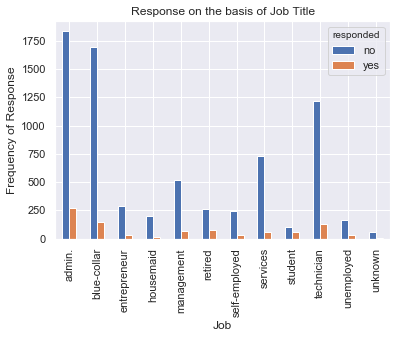

In [78]:
%matplotlib inline
pd.crosstab(train.profession,train.responded).plot(kind='bar')
plt.title('Response on the basis of Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Response')
plt.savefig('response_fre_job')

In [42]:
train['responded'].value_counts()

no     7310
yes     928
Name: responded, dtype: int64

## Response V/S non-response graph

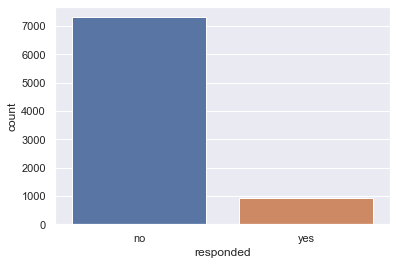

<Figure size 432x288 with 0 Axes>

In [45]:
sns.countplot(x = 'responded',data= train)
plt.show()
plt.savefig('response')

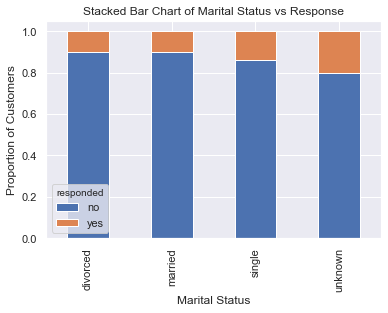

In [46]:
table=pd.crosstab(train.marital,train.responded)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Response')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('marital_status')

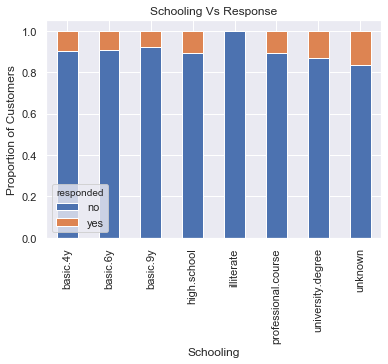

In [48]:
table=pd.crosstab(train.schooling,train.responded)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Schooling Vs Response')
plt.xlabel('Schooling')
plt.ylabel('Proportion of Customers')
plt.savefig('Schooling_response')

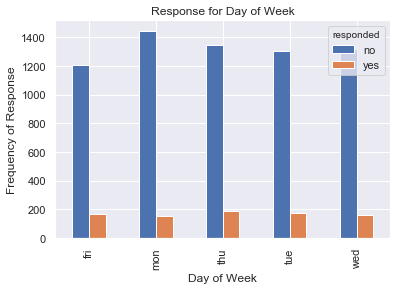

In [79]:
pd.crosstab(train.day_of_week,train.responded).plot(kind='bar')
plt.title('Response for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Response')
plt.savefig('res_dayofweek_bar')

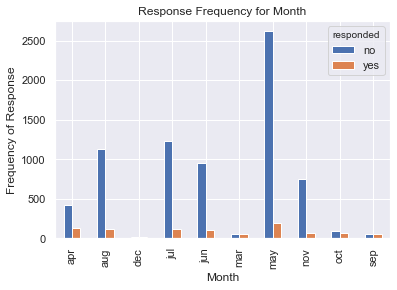

In [80]:
pd.crosstab(train.month,train.responded).plot(kind='bar')
plt.title('Response Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Response')
plt.savefig('pur_fre_month_bar')

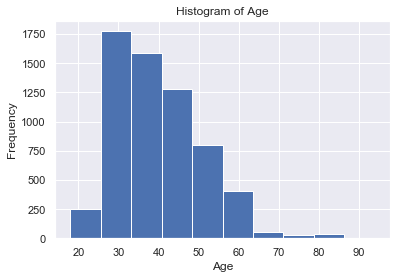

In [54]:
train.custAge.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

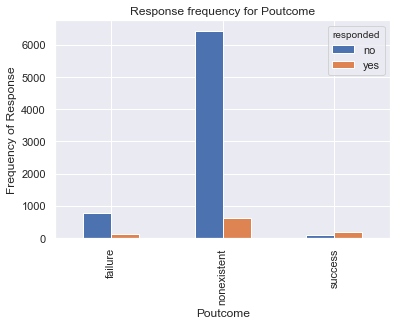

In [82]:
pd.crosstab(train.poutcome,train.responded).plot(kind='bar')
plt.title('Response frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Response')
plt.savefig('fre_pout_bar')

#### Adding a column type to distinguish between train and test

In [3]:
train['type']='train'
test['type']='test'

### Merging the train and test datasets

In [4]:
df = pd.concat([train,test])
df.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(41188, 25)

In [5]:
df.columns

Index(['campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'custAge',
       'day_of_week', 'default', 'emp.var.rate', 'euribor3m', 'housing', 'id',
       'loan', 'marital', 'month', 'nr.employed', 'pastEmail', 'pdays',
       'pmonths', 'poutcome', 'previous', 'profession', 'profit', 'responded',
       'schooling', 'type'],
      dtype='object')

### Handling Missing Data

#### Features having missing data

In [6]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

custAge        10056
day_of_week     4115
profit         40260
responded      32950
schooling      12176
dtype: int64

#### Distribution of missing data

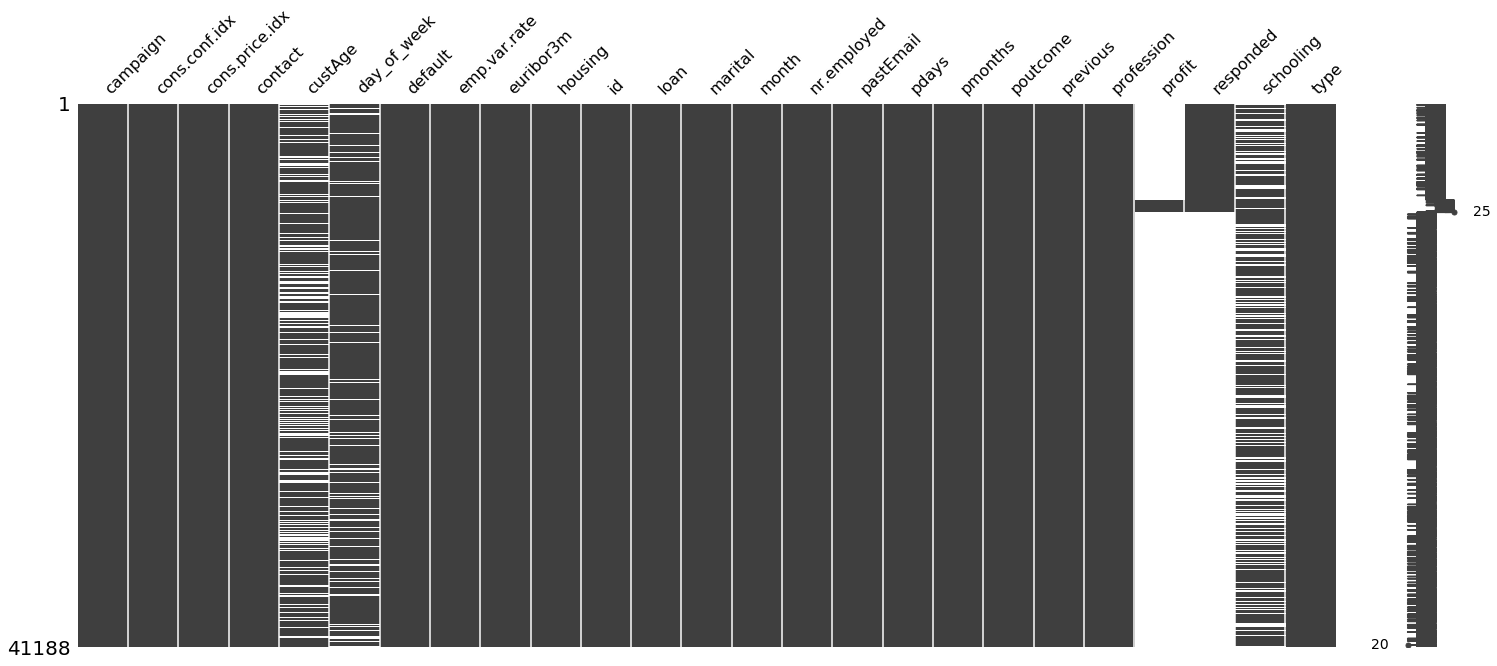

In [7]:
%matplotlib inline
import missingno as msno
msno.matrix(df)

#### Analysis of schooling

In [8]:
df['schooling'].value_counts()

university.degree      8599
high.school            6675
basic.9y               4295
professional.course    3689
basic.4y               2916
basic.6y               1605
unknown                1217
illiterate               16
Name: schooling, dtype: int64

In [9]:
df.groupby(['profession','schooling'])['schooling'].count().reset_index

<bound method Series.reset_index of profession  schooling          
admin.      basic.4y                 59
            basic.6y                 96
            basic.9y                344
            high.school            2354
            illiterate                1
                                   ... 
unknown     basic.9y                 28
            high.school              25
            professional.course       8
            university.degree        29
            unknown                  98
Name: schooling, Length: 90, dtype: int64>

#### Imputing schooling on the level of profession

In [10]:
edu_mode=[]
job_types = df.profession.value_counts().index
for job in job_types:
    mode = df[df.profession==job]['schooling'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=df.profession.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    df.loc[(df['schooling'].isnull()) & (df['profession']==j),'schooling'] = edu_map.loc[edu_map.index==j][0]
    
df['schooling'].value_counts()

university.degree      13672
high.school             8133
basic.9y                7028
professional.course     5676
basic.4y                3749
basic.6y                1605
unknown                 1309
illiterate                16
Name: schooling, dtype: int64

#### Imputing Age on the basis of 'marital','schooling','profession'

In [11]:
df_age = df[['marital','schooling','profession','custAge']]
df_age.dropna(inplace=True)
df_age.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(31132, 4)

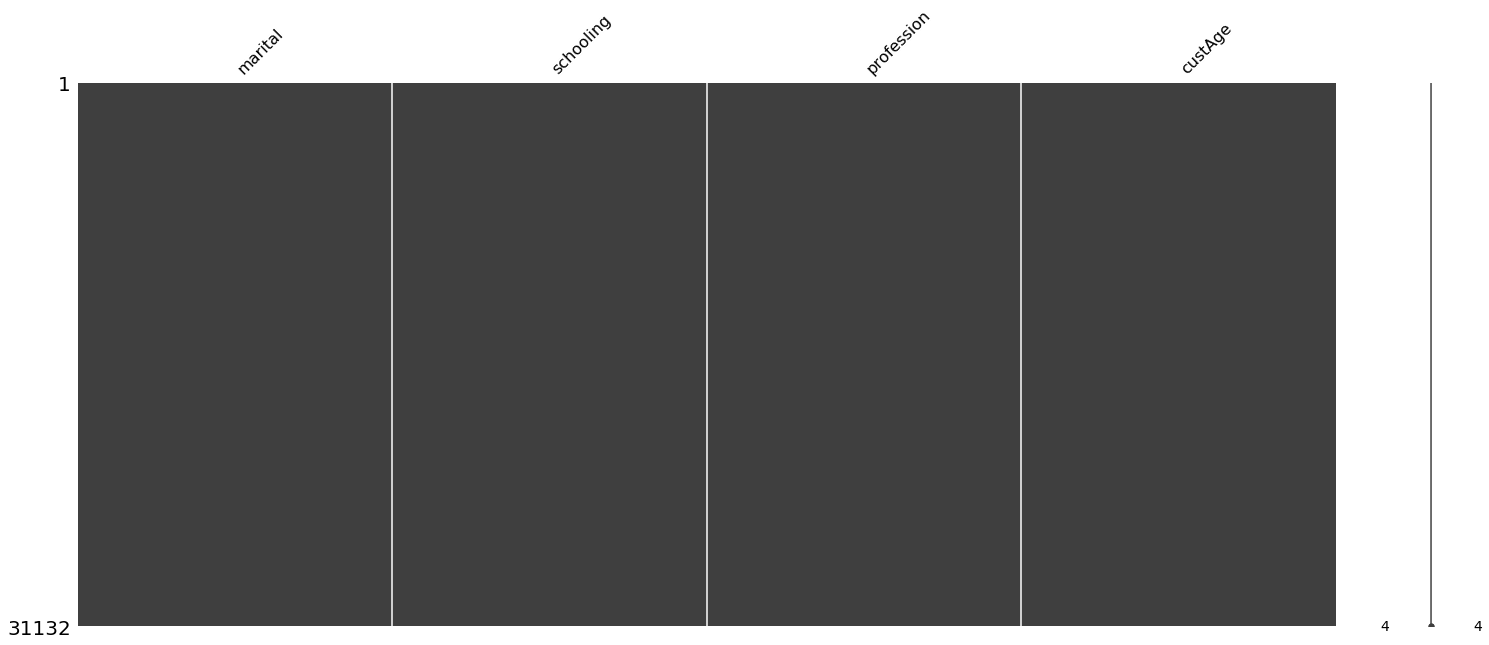

In [12]:
msno.matrix(df_age)

In [13]:
p=df_age.groupby(['marital','schooling','profession']).agg({'custAge':['median']}).reset_index()
p.columns=['marital','schooling','profession','median_age']
p

,marital,schooling,profession,median_age
0,divorced,basic.4y,admin.,59.0
1,divorced,basic.4y,blue-collar,47.0
2,divorced,basic.4y,entrepreneur,39.0
3,divorced,basic.4y,housemaid,50.5
4,divorced,basic.4y,management,32.0
...,...,...,...,...
266,unknown,university.degree,unemployed,43.5
267,unknown,university.degree,unknown,32.0
268,unknown,unknown,blue-collar,31.0
269,unknown,unknown,services,53.0


In [14]:
df_fin = pd.merge(df,p,how='inner',on=['marital','schooling','profession'])
df_fin.shape

(41178, 26)

In [15]:
df_fin.columns

Index(['campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'custAge',
       'day_of_week', 'default', 'emp.var.rate', 'euribor3m', 'housing', 'id',
       'loan', 'marital', 'month', 'nr.employed', 'pastEmail', 'pdays',
       'pmonths', 'poutcome', 'previous', 'profession', 'profit', 'responded',
       'schooling', 'type', 'median_age'],
      dtype='object')

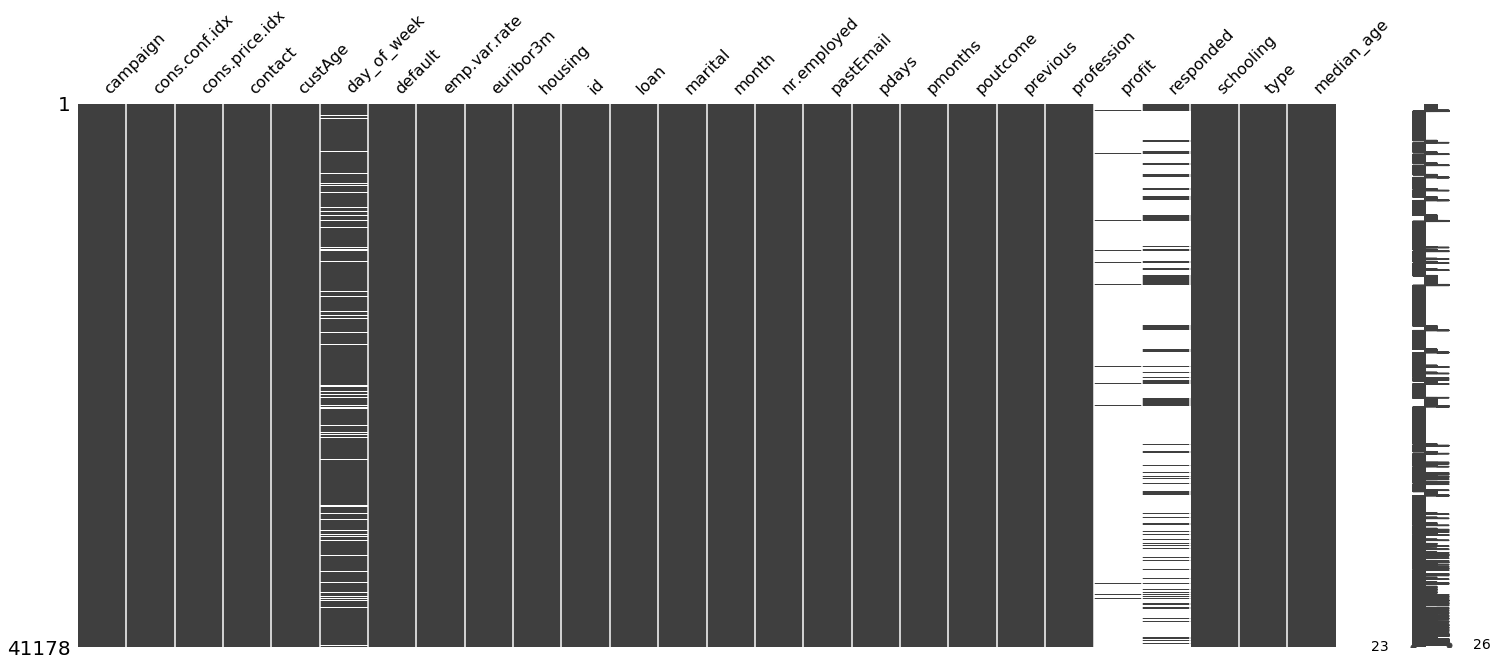

In [16]:
df_fin['custAge'].fillna(df_fin['median_age'],inplace=True)
msno.matrix(df_fin)

#### Imputing day_of_week

In [17]:
df_fin['day_of_week'].value_counts()

thu    7727
mon    7634
wed    7353
tue    7287
fri    7063
Name: day_of_week, dtype: int64

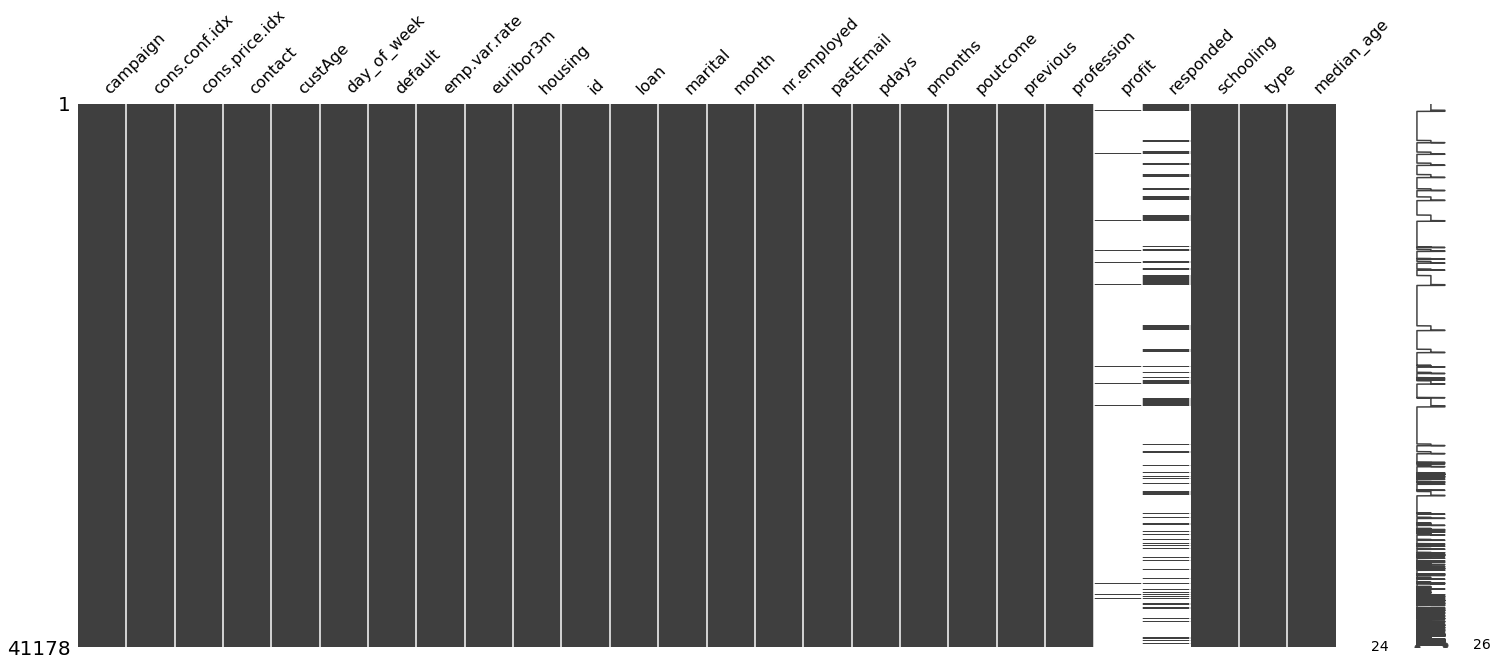

In [18]:
df_fin['day_of_week'].fillna(np.random.choice(['mon','tue','wed','thu','fri']),inplace=True)
msno.matrix(df_fin)

### Sample records after the imputation

In [19]:
df_fin.head(5)

,campaign,cons.conf.idx,cons.price.idx,contact,custAge,day_of_week,default,emp.var.rate,euribor3m,housing,...,pdays,pmonths,poutcome,previous,profession,profit,responded,schooling,type,median_age
0,2,-47.1,93.075,cellular,34.0,wed,no,-1.8,1.498,no,...,999,999.0,nonexistent,0,admin.,NaN,no,university.degree,train,32.0
1,3,-36.1,93.444,cellular,37.0,mon,no,1.4,4.965,no,...,999,999.0,nonexistent,0,admin.,NaN,no,university.degree,train,32.0
2,3,-41.8,94.465,telephone,32.0,thu,no,1.4,4.962,no,...,999,999.0,nonexistent,0,admin.,NaN,no,university.degree,train,32.0
3,1,-36.1,93.444,cellular,33.0,thu,no,1.4,4.964,yes,...,999,999.0,nonexistent,0,admin.,NaN,no,university.degree,train,32.0
4,1,-31.4,92.201,cellular,32.0,mon,no,-2.9,0.861,unknown,...,999,999.0,failure,2,admin.,NaN,no,university.degree,train,32.0


### Feature Selection on the Basis of Correlation

#### Correlation heatmap for all the numerical features

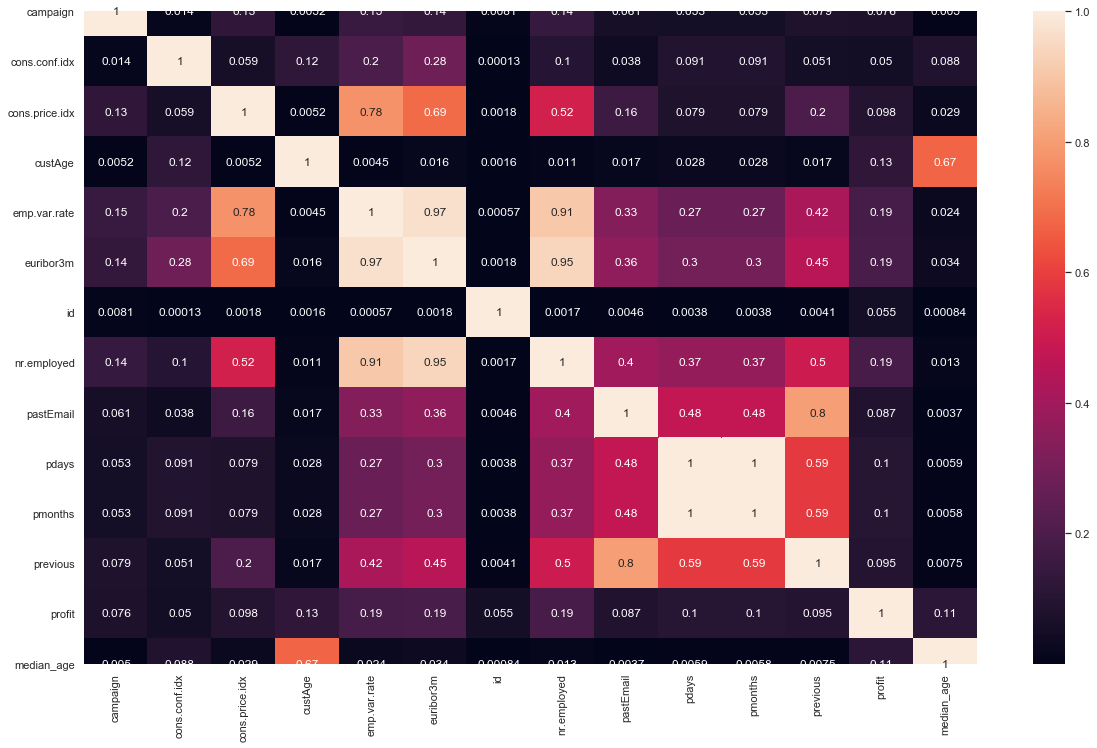

In [20]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_fin.corr().abs(),annot=True)

#### Analysing features with high correlation (>0.6) with each other 

In [21]:
corr_matrix = df_fin.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol = sol.to_frame()
sol.columns=['corr']
sol[sol['corr'] >  0.6]

corr
pdays          pmonths       0.999993
emp.var.rate   euribor3m     0.972244
euribor3m      nr.employed   0.945147
emp.var.rate   nr.employed   0.906960
pastEmail      previous      0.803536
cons.price.idx emp.var.rate  0.775283
               euribor3m     0.688164
custAge        median_age    0.672922

#### Removing pmonths as it is highly correlated to pdays.
#### Removing euribor3m as it is highly correlated to both emp.var.rate,cons.price.idx and nr.employed
#### Removing previous as it is highly correlated to pastEmail
#### Removing median_age and nr.employed for similar reasons

In [22]:
df_uncorr_fin = df_fin.drop(columns =['pmonths','euribor3m','nr.employed','previous', 
                                      'median_age'], axis = 1)

#### Re-evaluating correlations after dropping the above features

In [23]:
corr_matrix = df_uncorr_fin.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol = sol.to_frame()
sol.columns=['corr']
sol[sol['corr'] >  0.8]

,,corr


#### Existing features are no more correlated

### Features after imputation and removing correlated features

In [24]:
df_uncorr_fin.columns

Index(['campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'custAge',
       'day_of_week', 'default', 'emp.var.rate', 'housing', 'id', 'loan',
       'marital', 'month', 'pastEmail', 'pdays', 'poutcome', 'profession',
       'profit', 'responded', 'schooling', 'type'],
      dtype='object')

#### Storing id in a separate dataframe and removing id from df_uncorr_fin

In [25]:
res=df_uncorr_fin['id']
df_uncorr_fin.drop(columns=['id'],axis=1,inplace=True)

### Handling Categorical Variables

#### Binary Transformation of depended variable 'responded' 

In [26]:
df_uncorr_fin['responded'].value_counts()

no     7309
yes     928
Name: responded, dtype: int64

In [27]:
bin_yn = {'yes':1,'no':0}
df_uncorr_fin['responded']=df_uncorr_fin['responded'].map(bin_yn)
df_uncorr_fin['responded'].value_counts()

0.0    7309
1.0     928
Name: responded, dtype: int64

#### Creating dummies for the rest of the categorical variables

##### Identifying categorical variables

In [28]:
cat =[]
for i in df_uncorr_fin.columns:
    if df_uncorr_fin[i].dtypes=='O':
        cat.append(i)
        
cat

['contact',
 'day_of_week',
 'default',
 'housing',
 'loan',
 'marital',
 'month',
 'poutcome',
 'profession',
 'schooling',
 'type']

In [29]:
cat.remove('type')

##### Making dummies of the categorical variables

In [30]:
df_fin_new = pd.get_dummies(data=df_uncorr_fin,columns=cat)
df_fin_new.shape

(41178, 63)

### Separating the Train and Test Data 

In [31]:
df_train_fin = df_fin_new[df_fin_new['type']=='train']
df_test_fin = df_fin_new[df_fin_new['type']=='test']

print(df_train_fin.shape)
print(df_test_fin.shape)

(8237, 63)
(32941, 63)


#### Removing type and profit from both df_train_fin and df_test_fin

In [32]:
df_train_fin.drop(columns=['type','profit'],axis=1,inplace=True)
df_test_fin.drop(columns=['type','profit'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Detailed Info of df_train_fin and df_test_fin

In [83]:
df_train_fin.columns

Index(['campaign', 'cons.conf.idx', 'cons.price.idx', 'custAge',
       'emp.var.rate', 'pastEmail', 'pdays', 'responded', 'contact_cellular',
       'contact_telephone', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'profession_admin.', 'profession_blue-collar',
       'profession_entrepreneur', 'profession_housemaid',
       'profession_management', 'profession_retired',
       'profession_self-employed', 'profession_services', 'profession_student',
       'profession_technician', 'p

In [84]:
df_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32941 entries, 583 to 41177
Data columns (total 61 columns):
campaign                         32941 non-null int64
cons.conf.idx                    32941 non-null float64
cons.price.idx                   32941 non-null float64
custAge                          32941 non-null float64
emp.var.rate                     32941 non-null float64
pastEmail                        32941 non-null int64
pdays                            32941 non-null int64
responded                        0 non-null float64
contact_cellular                 32941 non-null uint8
contact_telephone                32941 non-null uint8
day_of_week_fri                  32941 non-null uint8
day_of_week_mon                  32941 non-null uint8
day_of_week_thu                  32941 non-null uint8
day_of_week_tue                  32941 non-null uint8
day_of_week_wed                  32941 non-null uint8
default_no                       32941 non-null uint8
default_unknown    

### Train-Test Split of the Training Data

In [85]:
X = df_train_fin.drop(columns = ['responded'], axis = 1)
y = df_train_fin['responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5765, 60)
(2472, 60)
(5765,)
(2472,)


### Checking the balance of the data with respect to responded

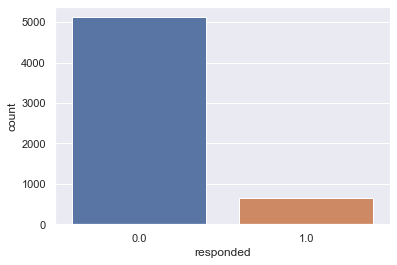

In [86]:
sns.countplot(y_train)

In [87]:
y_train.value_counts()

0.0    5121
1.0     644
Name: responded, dtype: int64

#### Data is highly imbalanced and it must be balanced with SMOTE technique.

### Balancing the data with SMOTE

In [88]:
smote = SMOTE(ratio='minority', random_state=0)
X_sm, y_sm = smote.fit_sample(X_train, y_train)

print(X_sm.shape)
print(y_sm.shape)

(10242, 60)
(10242,)


#### Balance of 'responded' after SMOTE

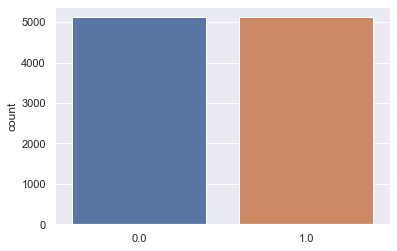

In [89]:
sns.countplot(y_sm)

#### Data is balanced now

### Creating function to see the distribution of data in 2D Space

In [90]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    plt.figure(figsize=(12, 9), dpi=80)
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

#### Distribution of the data in 2D space before SMOTE

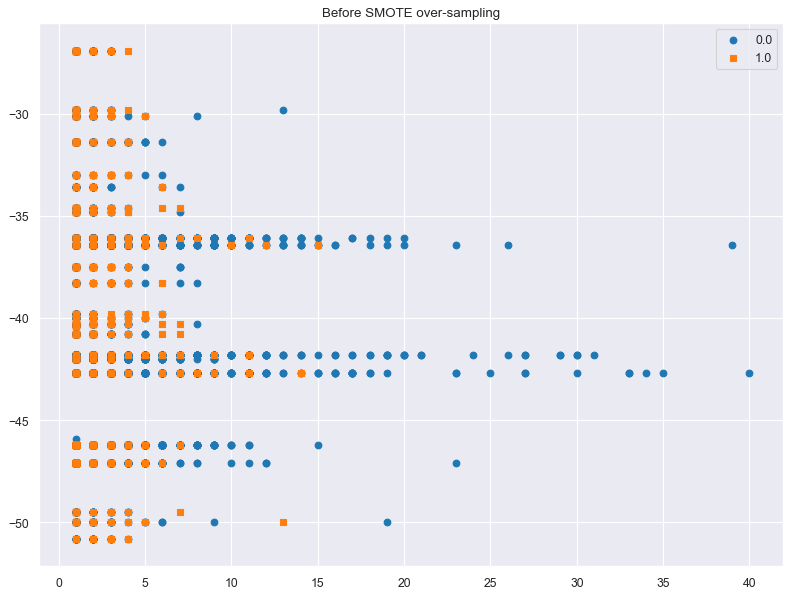

In [91]:
plot_2d_space(np.array(X), np.array(y), 'Before SMOTE over-sampling')

#### Distribution of data in 2D Space after SMOTE

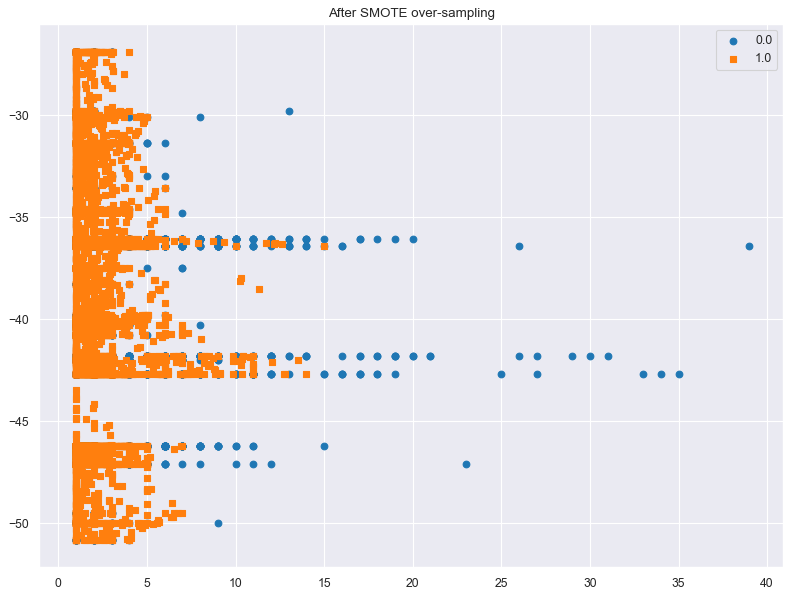

In [92]:
plot_2d_space(X_sm, y_sm, 'After SMOTE over-sampling')

### Category counts for test data of the Training Set

{0.0: 2188, 1.0: 284}


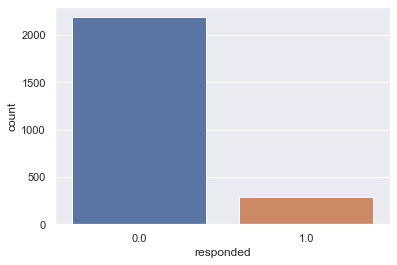

In [93]:
category, records = np.unique(y_test, return_counts= True)
cat_counts = dict(zip(category,records))

print(cat_counts)
sns.countplot(y_test)

### Function to return the metrics of the models

In [94]:
def score(model, test = X_test, y_true = y_test):
    
    pred = model.predict(test)

    print('Average precision-recall score RF:\t', round(average_precision_score(y_true, pred),4)*100)
    print()
    print("Area Under ROC Curve:\t",round(roc_auc_score(y_true,pred),4)*100)
    print()
    print(classification_report(y_true,pred))
    
    
    precision, recall, _ = precision_recall_curve(y_true, pred)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(y_true, pred)))
    
    
    
    fpr_rf, tpr_rf, _ = roc_curve(y_true, pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.step(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    #plt.fill_between(fpr_rf, tpr_rf, step='post', alpha=0.2, color='b')
    
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

## ML Models for Predicting Responded 

### 1. Logistic Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Average precision-recall score RF:	 23.880000000000003

Area Under ROC Curve:	 72.87

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      2188
         1.0       0.31      0.65      0.42       284

    accuracy                           0.79      2472
   macro avg       0.63      0.73      0.64      2472
weighted avg       0.87      0.79      0.82      2472



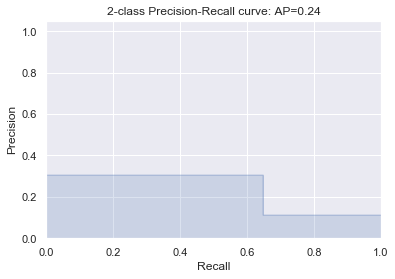

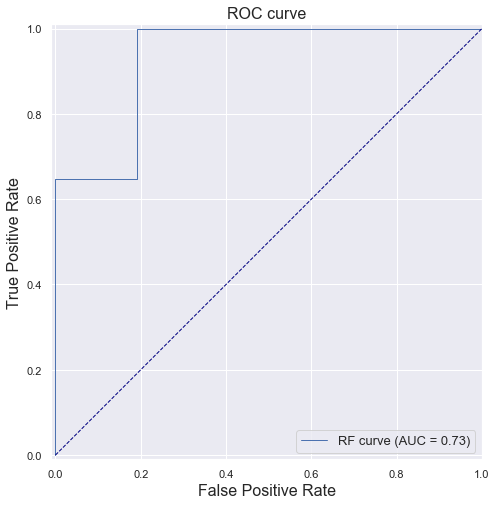

In [95]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_sm,y_sm)
y_pred_train = lr_model.predict(X_test)

score(lr_model)

### 2. Decision Tree

In [96]:
dtree = DecisionTreeClassifier()
dtree.fit(X_sm,y_sm)

pprint(dtree.get_params())

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


#### Training DecisionTree with GridSearchCV to find the optimal parameters

In [97]:
param_grid_treeclass = {
            'max_depth' : range(1,20),
            'min_samples_leaf' : range(2,50)
            }

CV_dtree_class = GridSearchCV(estimator =dtree, param_grid = param_grid_treeclass , scoring='recall', verbose = 1, n_jobs = -1)
CV_dtree_class.fit(X_sm, y_sm)

best_parameters_dtree_class=CV_dtree_class.best_params_
print(best_parameters_dtree_class)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 912 candidates, totalling 2736 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   28.2s


{'max_depth': 13, 'min_samples_leaf': 3}


[Parallel(n_jobs=-1)]: Done 2736 out of 2736 | elapsed:   55.0s finished


#### Using the optimal parameters for decision tree

Average precision-recall score RF:	 23.35

Area Under ROC Curve:	 65.16

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      2188
         1.0       0.44      0.36      0.40       284

    accuracy                           0.87      2472
   macro avg       0.68      0.65      0.66      2472
weighted avg       0.86      0.87      0.87      2472



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


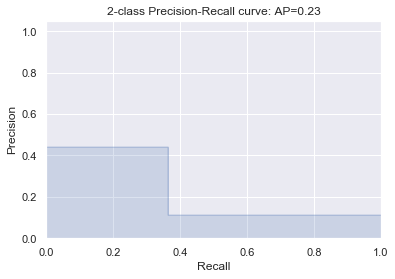

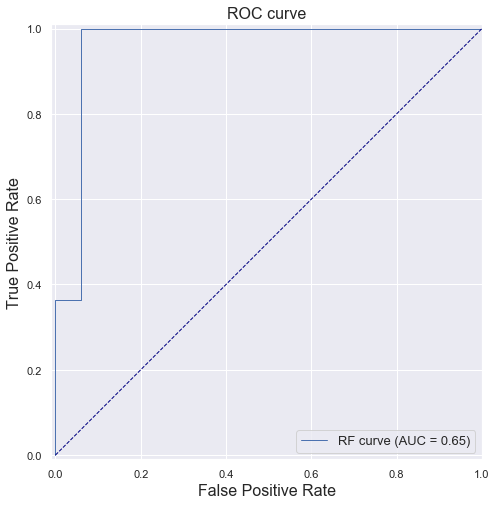

In [98]:
dtree = DecisionTreeClassifier(max_depth=12,min_samples_leaf=3)

dtree.fit(X_sm,y_sm)
y_pred_train = dtree.predict(X_test)

score(dtree)

### 3. Random Forest

In [99]:
rf = RandomForestClassifier()
rf.fit(X_sm,y_sm)

pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Training Random Forest with GridSearchCV to find the optimal parameters

In [100]:
param_grid_rf = {
            'max_depth' : range(1,20),
            'min_samples_leaf' : range(2,50),
            'n_estimators': range(2,30),
            'oob_score':[True]
            }

CV_rf_class = GridSearchCV(estimator =rf, param_grid = param_grid_rf , scoring='recall', verbose = 1, n_jobs = -1)
CV_rf_class.fit(X_sm, y_sm)

best_parameters_rf_class=CV_rf_class.best_params_
print(best_parameters_rf_class)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 25536 candidates, totalling 76608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 24, 'oob_score': True}


Average precision-recall score RF:	 16.42

Area Under ROC Curve:	 62.83

              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84      2188
         1.0       0.22      0.48      0.30       284

    accuracy                           0.74      2472
   macro avg       0.57      0.63      0.57      2472
weighted avg       0.84      0.74      0.78      2472



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


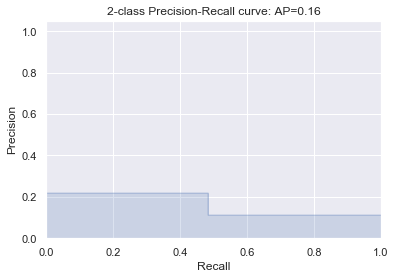

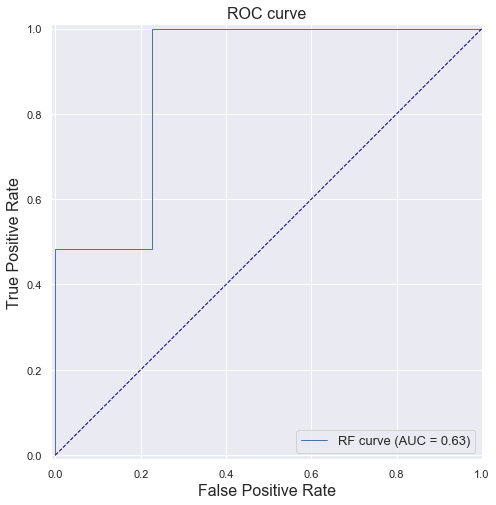

In [101]:
rf = RandomForestClassifier(max_depth=1,min_samples_leaf=7,n_estimators=2,oob_score=True)

rf.fit(X_sm,y_sm)
y_pred_train = rf.predict(X_test)

score(rf)

### Logistic Regression is giving the best result

In [102]:
df_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32941 entries, 583 to 41177
Data columns (total 61 columns):
campaign                         32941 non-null int64
cons.conf.idx                    32941 non-null float64
cons.price.idx                   32941 non-null float64
custAge                          32941 non-null float64
emp.var.rate                     32941 non-null float64
pastEmail                        32941 non-null int64
pdays                            32941 non-null int64
responded                        0 non-null float64
contact_cellular                 32941 non-null uint8
contact_telephone                32941 non-null uint8
day_of_week_fri                  32941 non-null uint8
day_of_week_mon                  32941 non-null uint8
day_of_week_thu                  32941 non-null uint8
day_of_week_tue                  32941 non-null uint8
day_of_week_wed                  32941 non-null uint8
default_no                       32941 non-null uint8
default_unknown    

### Predicting Profit in the Test dataset using Logistic Regression

In [103]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_sm,y_sm)
y_pred = lr_model.predict(df_test_fin.drop(columns=['responded'],axis=1))

df_test_fin['responded']=y_pred
df_test_fin.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,campaign,cons.conf.idx,cons.price.idx,custAge,emp.var.rate,pastEmail,pdays,responded,contact_cellular,contact_telephone,...,profession_unemployed,profession_unknown,schooling_basic.4y,schooling_basic.6y,schooling_basic.9y,schooling_high.school,schooling_illiterate,schooling_professional.course,schooling_university.degree,schooling_unknown
583,1,-36.1,93.444,30.0,1.4,0,999,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
584,2,-42.7,93.918,30.0,1.4,0,999,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
585,3,-42.7,93.918,29.0,1.4,0,999,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
586,2,-42.0,93.200,41.0,-0.1,0,999,0.0,1,0,...,0,0,0,0,0,0,0,0,1,0
587,6,-41.8,94.465,28.0,1.4,0,999,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [104]:
df_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32941 entries, 583 to 41177
Data columns (total 61 columns):
campaign                         32941 non-null int64
cons.conf.idx                    32941 non-null float64
cons.price.idx                   32941 non-null float64
custAge                          32941 non-null float64
emp.var.rate                     32941 non-null float64
pastEmail                        32941 non-null int64
pdays                            32941 non-null int64
responded                        32941 non-null float64
contact_cellular                 32941 non-null uint8
contact_telephone                32941 non-null uint8
day_of_week_fri                  32941 non-null uint8
day_of_week_mon                  32941 non-null uint8
day_of_week_thu                  32941 non-null uint8
day_of_week_tue                  32941 non-null uint8
day_of_week_wed                  32941 non-null uint8
default_no                       32941 non-null uint8
default_unknown

### Yes vs No for responded in Test Data

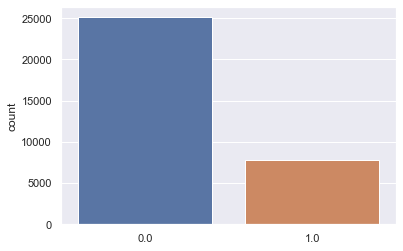

In [105]:
sns.countplot(y_pred)

In [116]:
df_test_fin.to_csv('test_fin.csv',sep=',')

### Separating only cases where customer responded (responded =1)

In [106]:
df_train_new = df_fin_new[df_fin_new['type']=='train']
df_train_responded = df_train_new[df_train_new['responded']==1]
df_test_responded = df_test_fin[df_test_fin['responded']==1]

print(df_train_responded.shape)
print(df_test_responded.shape)

(928, 63)
(7817, 61)


### Distribution of profit in Training Data for customers who responded

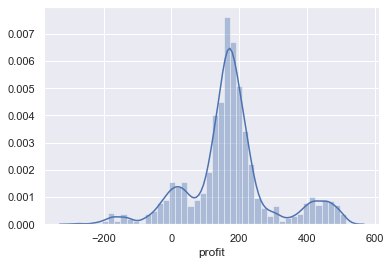

In [107]:
sns.distplot(df_train_responded['profit'])

#### Profit is normally distributed

In [108]:
df_train_responded.drop(columns=['type'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Train Test Split for Predicting Profit in Train Data

In [109]:
X = df_train_responded.drop(columns=['profit'],axis=1)
y = df_train_responded[['profit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(649, 61)
(279, 61)
(649, 1)
(279, 1)


## ML Models to predict the Profit for customers who responded

### 1. Linear Regression

In [110]:
lr = LinearRegression()

lr.fit(X_train,y_train)
y_pred_train = lr.predict(X_test)

print('R-squared: {:.4f} %'.format(r2_score(y_test, y_pred_train)*100))
print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_pred_train))))

R-squared: 93.0071 %
RMSE: 35.4507


### 2. Decision Tree Regressor

In [111]:
dtree_reg = DecisionTreeRegressor()

dtree_reg.fit(X_train,y_train)
pprint(dtree_reg.get_params())

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


#### Using GridSearchCV to get optimal parameters

In [112]:
param_grid_treereg = {
            'max_depth' : range(1,20),
            'min_samples_leaf' : range(2,50)
            }

CV_dtree_reg = GridSearchCV(estimator =dtree_reg, param_grid = param_grid_treereg , scoring='neg_mean_squared_error', verbose = 1, n_jobs = -1)
CV_dtree_reg.fit(X_sm, y_sm)

best_parameters_dtree_reg=CV_dtree_reg.best_params_
print(best_parameters_dtree_reg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 912 candidates, totalling 2736 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2412 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 2736 out of 2736 | elapsed:   53.2s finished


{'max_depth': 18, 'min_samples_leaf': 3}


#### Using the optimal parameters for DecisionTree Regressor

In [113]:
dtree_reg = DecisionTreeRegressor(max_depth=19,min_samples_leaf=3)

dtree_reg.fit(X_train,y_train)
y_pred_train = lr.predict(X_test)

print('R-squared: {:.4f} %'.format(r2_score(y_test, y_pred_train)*100))
print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_pred_train))))

R-squared: 93.0071 %
RMSE: 35.4507


### Both Linear Regression and Decision Tree are giving good results

### Predicting Profit in Test Dataset with Linear Regression

In [114]:
lr = LinearRegression()

lr.fit(X_train,y_train)
y_pred = lr.predict(df_test_responded)

df_test_responded['profit']=y_pred
df_test_responded.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,campaign,cons.conf.idx,cons.price.idx,custAge,emp.var.rate,pastEmail,pdays,responded,contact_cellular,contact_telephone,...,profession_unknown,schooling_basic.4y,schooling_basic.6y,schooling_basic.9y,schooling_high.school,schooling_illiterate,schooling_professional.course,schooling_university.degree,schooling_unknown,profit
595,1,-46.2,92.893,32.0,-1.8,0,999,1.0,1,0,...,0,0,0,0,0,0,0,1,0,158.571940
599,1,-37.5,94.199,32.0,-1.1,3,999,1.0,1,0,...,0,0,0,0,0,0,0,1,0,161.963012
602,2,-40.8,92.963,32.0,-2.9,3,4,1.0,1,0,...,0,0,0,0,0,0,0,1,0,162.893591
605,1,-33.6,92.469,27.0,-2.9,0,999,1.0,0,1,...,0,0,0,0,0,0,0,1,0,155.282270
606,2,-46.2,92.893,34.0,-1.8,0,999,1.0,1,0,...,0,0,0,0,0,0,0,1,0,156.301641
